In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# 加载mnist数据集
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=10, shuffle=True)
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=10, shuffle=True)

# 超参数设置
batch_size = 10
epoch = 5
learning_rate = 0.001
# 设置扰动最大就是50
epsilon = 5/256
iter = 10
# 生成对抗样本的个数
adver_nums = 100

# LeNet Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# 选择设备
device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")

# 初始化网络，并定义优化器
simple_model = Net().to(device)
optimizer1 = torch.optim.SGD(simple_model.parameters(),lr = learning_rate,momentum=0.9)
print (simple_model)

100%|█████████████████████████████████████████████████████████████████████████████████| 9912422/9912422 [00:01<00:00, 8698302.47it/s]


Extracting ../data\MNIST\raw\train-images-idx3-ubyte.gz to ../data\MNIST\raw



100%|██████████████████████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 688681.85it/s]


Extracting ../data\MNIST\raw\train-labels-idx1-ubyte.gz to ../data\MNIST\raw



100%|█████████████████████████████████████████████████████████████████████████████████| 1648877/1648877 [00:00<00:00, 5710030.11it/s]


Extracting ../data\MNIST\raw\t10k-images-idx3-ubyte.gz to ../data\MNIST\raw



100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<?, ?it/s]

Extracting ../data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ../data\MNIST\raw

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [2]:
# 训练模型
def train(model,optimizer):
  for i in range(epoch):
    for j,(data,target) in tqdm(enumerate(train_loader)):
      data = data.to(device)
      target = target.to(device)
      logit = model(data)
      loss = F.nll_loss(logit,target)
      model.zero_grad()
      # 如下：因为其中的loss是单个tensor就不能用加上一个tensor的维度限制
      loss.backward()
      # 如下有两种你形式表达，一种是原生，一种是使用optim优化函数直接更新参数
      # 为什么原生的训练方式没有效果？？？代表参数没有更新，就离谱。
      # 下面的detach与requires_grad_有讲究哦，终于明白了；但是为什么下面代码不能work还是没搞懂
      # for params in model.parameters():
      #   params = (params - learning_rate * params.grad).detach().requires_grad_()
      optimizer.step()
      if j % 1000 == 0:
        print ('第{}个数据，loss值等于{}'.format(j,loss))
train(simple_model,optimizer1)

# 罪魁祸首就是你，没有固定住dropout层的神经元怎么能做测试呢？你模型都没固定，那不是一个输入，会有多种输出值
# 真是被你害死了！！！
simple_model.eval()
# 模型测试
def test(model,name):
  correct_num = torch.tensor(0).to(device)
  for j,(data,target) in tqdm(enumerate(test_loader)):
    data = data.to(device)
    target = target.to(device)
    logit = model(data)
    pred = logit.max(1)[1]
    num = torch.sum(pred==target)
    correct_num = correct_num + num
  print (correct_num)
  print ('\n{} correct rate is {}'.format(name,correct_num/10000))
test(simple_model,'simple model')

25it [00:05,  6.45it/s]

第0个数据，loss值等于2.3108458518981934


1045it [00:08, 463.12it/s]

第1000个数据，loss值等于1.4178889989852905


2040it [00:10, 469.53it/s]

第2000个数据，loss值等于0.36330536007881165


3059it [00:13, 384.48it/s]

第3000个数据，loss值等于0.4649326801300049


4070it [00:15, 382.71it/s]

第4000个数据，loss值等于0.43273481726646423


5066it [00:18, 455.61it/s]

第5000个数据，loss值等于0.23465128242969513


6000it [00:20, 292.60it/s]
41it [00:00, 407.68it/s]

第0个数据，loss值等于0.1489757001399994


1084it [00:02, 436.92it/s]

第1000个数据，loss值等于0.8151337504386902


2073it [00:04, 418.45it/s]

第2000个数据，loss值等于0.06031598523259163


3082it [00:07, 405.14it/s]

第3000个数据，loss值等于0.0277008805423975


4077it [00:10, 433.43it/s]

第4000个数据，loss值等于0.22981207072734833


5074it [00:12, 421.73it/s]

第5000个数据，loss值等于0.7503430247306824


6000it [00:15, 393.84it/s]
44it [00:00, 436.58it/s]

第0个数据，loss值等于0.017290553078055382


1071it [00:02, 375.52it/s]

第1000个数据，loss值等于0.13427135348320007


2040it [00:05, 403.55it/s]

第2000个数据，loss值等于0.3412632346153259


3062it [00:08, 368.63it/s]

第3000个数据，loss值等于0.5854917168617249


4057it [00:10, 407.01it/s]

第4000个数据，loss值等于0.16378754377365112


5047it [00:12, 374.82it/s]

第5000个数据，loss值等于0.221134752035141


6000it [00:15, 393.83it/s]
78it [00:00, 395.36it/s]

第0个数据，loss值等于0.08660111576318741


1071it [00:02, 503.60it/s]

第1000个数据，loss值等于0.5789746046066284


2070it [00:04, 462.56it/s]

第2000个数据，loss值等于0.06485167890787125


3051it [00:06, 412.27it/s]

第3000个数据，loss值等于0.1014094352722168


4082it [00:09, 481.79it/s]

第4000个数据，loss值等于0.11686824262142181


5079it [00:11, 456.04it/s]

第5000个数据，loss值等于1.573833703994751


6000it [00:13, 458.69it/s]
39it [00:00, 369.87it/s]

第0个数据，loss值等于0.8652453422546387


1048it [00:02, 494.21it/s]

第1000个数据，loss值等于0.011843432672321796


2070it [00:04, 485.26it/s]

第2000个数据，loss值等于0.7207215428352356


3092it [00:06, 508.11it/s]

第3000个数据，loss值等于0.13809837400913239


4049it [00:08, 391.82it/s]

第4000个数据，loss值等于0.0931849330663681


5034it [00:11, 391.29it/s]

第5000个数据，loss值等于0.19852998852729797


6000it [00:13, 438.77it/s]
1000it [00:01, 687.00it/s]

tensor(9799, device='cuda:0')

simple model correct rate is 0.9799000024795532


In [3]:
import numpy as np
from torch.autograd import Variable
import torch as torch
import copy
# 下面导入的类是很早版本的，现在版本已经没有了
# from torch.autograd.gradcheck import zero_gradients


def deepfool(image, net, num_classes=10, overshoot=0.02, max_iter=100):

    """
       :param image: Image of size HxWx3
       :param net: network (input: images, output: values of activation **BEFORE** softmax).
       :param num_classes: num_classes (limits the number of classes to test against, by default = 10)
       :param overshoot: used as a termination criterion to prevent vanishing updates (default = 0.02).
       :param max_iter: maximum number of iterations for deepfool (default = 50)
       :return: minimal perturbation that fools the classifier, number of iterations that it required, new estimated_label and perturbed image
    """
    is_cuda = torch.cuda.is_available()

    if is_cuda:
        # print("Using GPU")
        image = image.cuda()
        net = net.cuda()


    f_image = net.forward(Variable(image[None, :, :, :], requires_grad=True)).data.cpu().numpy().flatten()
    I = (np.array(f_image)).flatten().argsort()[::-1]

    I = I[0:num_classes]
    label = I[0]

    input_shape = image.cpu().numpy().shape
    pert_image = copy.deepcopy(image)
    w = np.zeros(input_shape)
    r_tot = np.zeros(input_shape)

    loop_i = 0

    x = Variable(pert_image[None, :], requires_grad=True)
    fs = net.forward(x)
    fs_list = [fs[0,I[k]] for k in range(num_classes)]
    k_i = label

    while k_i == label and loop_i < max_iter:

        pert = np.inf
        fs[0, I[0]].backward(retain_graph=True)
        grad_orig = x.grad.data.cpu().numpy().copy()

        for k in range(1, num_classes):
            if x.grad is not None:
              x.grad.zero_()

            fs[0, I[k]].backward(retain_graph=True)
            cur_grad = x.grad.data.cpu().numpy().copy()

            # set new w_k and new f_k
            w_k = cur_grad - grad_orig
            f_k = (fs[0, I[k]] - fs[0, I[0]]).data.cpu().numpy()

            pert_k = abs(f_k)/np.linalg.norm(w_k.flatten())

            # determine which w_k to use
            if pert_k < pert:
                pert = pert_k
                w = w_k

        # compute r_i and r_tot
        # Added 1e-4 for numerical stability
        r_i =  (pert+1e-4) * w / np.linalg.norm(w)
        r_tot = np.float32(r_tot + r_i)

        if is_cuda:
            pert_image = image + (1+overshoot)*torch.from_numpy(r_tot).cuda()
        else:
            pert_image = image + (1+overshoot)*torch.from_numpy(r_tot)

        x = Variable(pert_image, requires_grad=True)
        fs = net.forward(x)
        k_i = np.argmax(fs.data.cpu().numpy().flatten())

        loop_i += 1
    # print (net.forward(x).data.cpu().numpy().flatten())
    # print (loop_i)
    # print ('k_i equal to {}'.format(k_i))
    # print ('target equal to {}'.format(label))
    r_tot = (1+overshoot)*r_tot

    return r_tot, loop_i, label, k_i, pert_image


adver_nums = 100
# 这几个变量主要用于之后的测试以及可视化
adver_example_by_FOOL = torch.zeros((batch_size,1,28,28)).to(device)
adver_target = torch.zeros(batch_size).to(device)
clean_example = torch.zeros((batch_size,1,28,28)).to(device)
clean_target = torch.zeros(batch_size).to(device)
# 从test_loader中选取1000个干净样本，使用deepfool来生成对抗样本
for i,(data,target) in enumerate(test_loader):
  if i >= adver_nums/batch_size :
    break
  if i == 0:
    clean_example = data
  else:
    clean_example = torch.cat((clean_example,data),dim = 0)
    
  cur_adver_example_by_FOOL = torch.zeros_like(data).to(device)

  for j in range(batch_size):
    r_rot,loop_i,label,k_i,pert_image = deepfool(data[j],simple_model)
    cur_adver_example_by_FOOL[j] = pert_image
  
  # 使用对抗样本攻击VGG模型
  pred = simple_model(cur_adver_example_by_FOOL).max(1)[1]
  # print (simple_model(cur_adver_example_by_FOOL).max(1)[1])
  if i == 0:
    adver_example_by_FOOL = cur_adver_example_by_FOOL
    clean_target = target
    adver_target = pred
  else:
    adver_example_by_FOOL = torch.cat((adver_example_by_FOOL , cur_adver_example_by_FOOL), dim = 0)
    clean_target = torch.cat((clean_target,target),dim = 0)
    adver_target = torch.cat((adver_target,pred),dim = 0)

print (adver_example_by_FOOL.shape)
# print (adver_target)
print (clean_example.shape)
# print (clean_target)


torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])


In [4]:
import torch.utils.data as Data
def adver_attack_vgg(model,adver_example,target,name):
  adver_dataset = Data.TensorDataset(adver_example, target)
  loader = Data.DataLoader(
    dataset=adver_dataset,      # 数据，封装进Data.TensorDataset()类的数据
    batch_size=batch_size      # 每块的大小
    )
  correct_num = torch.tensor(0).to(device)
  for j,(data,target) in tqdm(enumerate(loader)):
    data = data.to(device)
    target = target.to(device)
    pred = model.forward(data).max(1)[1]
    num = torch.sum(pred==target)
    correct_num = correct_num + num
  print (correct_num)
  print ('\n{} correct rate is {}'.format(name,correct_num/adver_nums))
      
adver_attack_vgg(simple_model,adver_example_by_FOOL,clean_target,'simple model')

10it [00:00, 593.82it/s]

tensor(5, device='cuda:0')

simple model correct rate is 0.04999999701976776


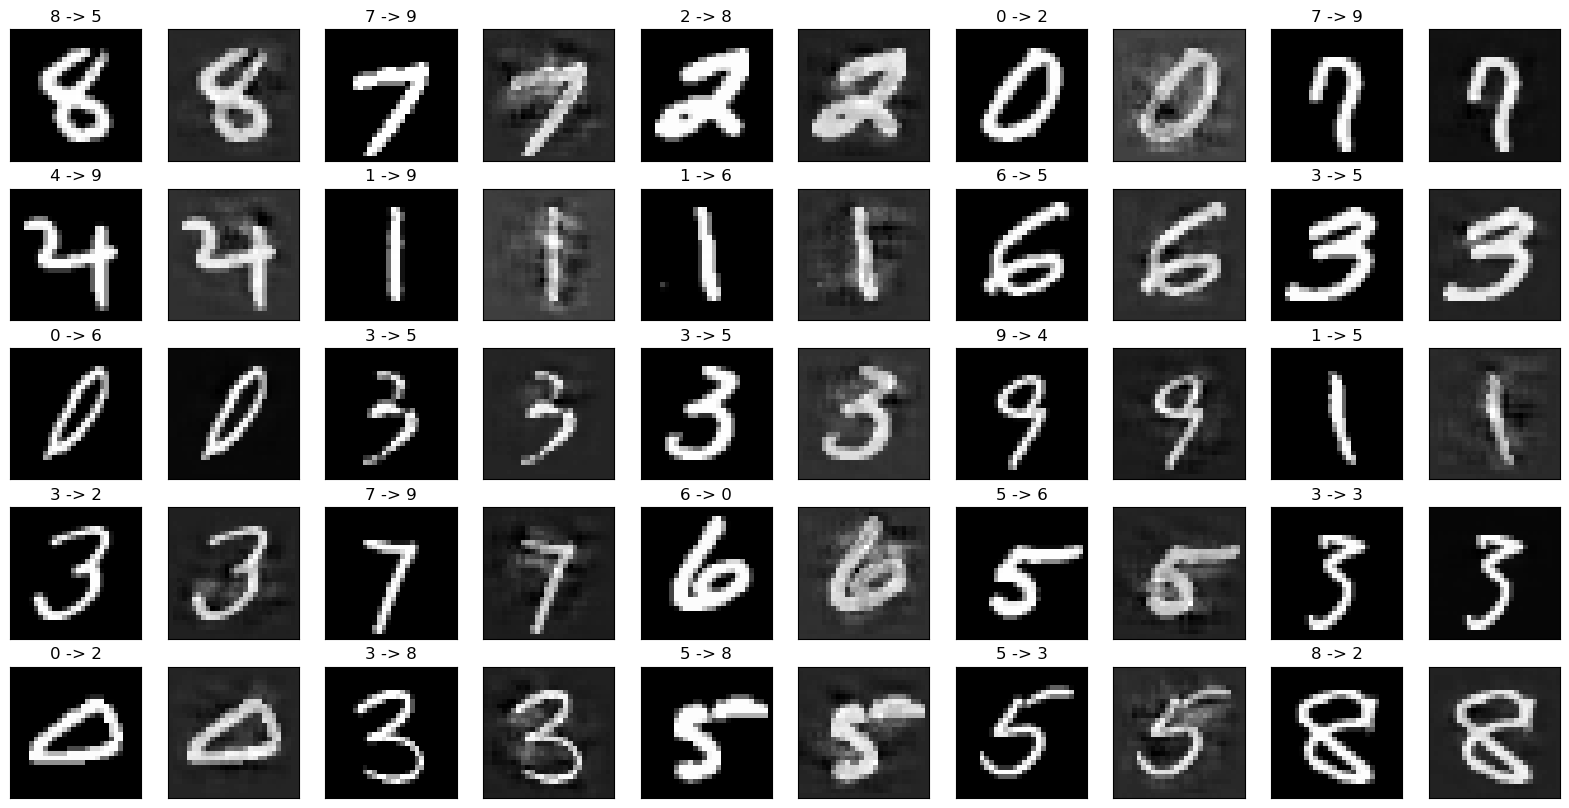

In [5]:
def plot_clean_and_adver(adver_example,adver_target,clean_example,clean_target):
  n_cols = 5
  n_rows = 5
  cnt = 1
  cnt1 = 1
  plt.figure(figsize=(n_cols*4,n_rows*2))
  for i in range(n_cols):
    for j in range(n_rows):
      plt.subplot(n_cols,n_rows*2,cnt1)
      plt.xticks([])
      plt.yticks([])
      plt.title("{} -> {}".format(clean_target[cnt], adver_target[cnt]))
      plt.imshow(clean_example[cnt].reshape(28,28).to('cpu').detach().numpy(),cmap='gray')
      plt.subplot(n_cols,n_rows*2,cnt1+1)
      plt.xticks([])
      plt.yticks([])
      # plt.title("{} -> {}".format(clean_target[cnt], adver_target[cnt]))
      plt.imshow(adver_example[cnt].reshape(28,28).to('cpu').detach().numpy(),cmap='gray')
      cnt = cnt + 1
      cnt1 = cnt1 + 2

plot_clean_and_adver(adver_example_by_FOOL,adver_target,clean_example,clean_target)
